# This notebook provides a slider to compare different physics parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters
from exp_analysis_class import exp_analysis

In [3]:
case = 'heavy'
D_or_M = 'majorana'
save_folder = (f'../fig/{case}/4_analysis_variables_plots/')
!mkdir -p $save_folder
my_exp_analysis = exp_analysis(case, D_or_M)
my_exp_analysis.load_df_base(1000000)

loading df base
initialising df base


## Slider for physics distributions

In [4]:
@interact(var=widgets.Dropdown(
                options=list(my_exp_analysis.df_base.columns.to_frame().loc[:, 0].values),
                description='Variable:',
                disabled=False,
            ),
          bins=widgets.IntSlider(min=1, max=50, step=1, value=10, continuous_update=False),
          hist_range=widgets.FloatRangeSlider(
                value=[0, 5],
                min=0,
                max=1e10,
                step=0.1,
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
            ),
          m4=widgets.FloatSlider(min=0.005, max=1, step=0.025, value=0.3, continuous_update=False), 
          mz=widgets.FloatSlider(min=0.005, max=10, step=0.005, value=2, continuous_update=False), 
          ctau=widgets.FloatLogSlider(
                base=10,
                min=-2, # max exponent of base
                max=3, # min exponent of base
                step=0.2, # exponent step
                value=25,
            ),
          kernel=widgets.Dropdown(
                options=['epa', 'gaus'],
                description='Kernel type:',
                disabled=False,
            ),
          smooth_m4=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.03, continuous_update=False), 
          smooth_mz=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.005, continuous_update=False), 
          selection_step=widgets.RadioButtons(
                options=['no_selection', 'cut_based', 'geometric', 'geometric_cut_based'],
                value='no_selection',
                description='selection:',
            ),
          df=fixed(my_exp_analysis.df_base),
         exp_analysis = fixed(my_exp_analysis))

def output_distrib(exp_analysis, df, var, bins, hist_range, m4, mz, ctau, kernel, smooth_m4, smooth_mz, selection_step):
    
    m4_values = df['m4'].values
    mz_values = df['mzprime'].values
    df_values = np.stack([m4_values, mz_values], axis=-1)
    this_kde_weights = exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])
    weight_values = this_kde_weights * df['actual_weight'].values

    if selection_step == 'no_selection':
        pass
    if 'cut_based' in selection_step:
        weight_values *= df['cut_based'].values
    if 'geometric' in selection_step:
        exp_analysis.decay_in_tpc(df, ctau)
        weight_values *= df[f'decay_in_tpc_{ctau}']

    plt.hist(df[var],
             range=hist_range,
             bins=bins,
             weights=weight_values,
             histtype='step',
             label=f'kde2D, from $m_4$ in [{m4_values.min():.2g}, {m4_values.max():.2g}], $m_Z$ in [{mz_values.min():.2g}, {mz_values.max():.2g}]\nexpected events = {weight_values.sum():.1f}')
    plt.ylim(bottom=0)
    plt.xlabel(f"{var}")
    plt.ylabel(f"Expected number of entries / {(hist_range[1]-hist_range[0])/bins:.2g}")
    plt.title(f"$m_4$ = {m4:.2g} GeV, $m_Z$ = {mz:.2g} GeV, $c\\tau$ = {ctau:.2g} cm\n$\sigma_{{m_4}}$ = {smooth_m4:.2g} GeV, $\sigma_{{m_Z}}$ = {smooth_mz:.2g} GeV\nselection step = {selection_step}, expected events = {weight_values.sum():.1f}")
    return weight_values.sum()

interactive(children=(Dropdown(description='Variable:', options=('weight', 'm4', 'mzprime', 'ee_mass', 'ee_ene…

## Distribution of events throughout detector

In [9]:
ctau = 20
m4 = 0.1
mz = 1.25

m4_values = my_exp_analysis.df_base['m4'].values
mz_values = my_exp_analysis.df_base['mzprime'].values
df_values = np.stack([m4_values, mz_values], axis=-1)
smooth_m4, smooth_mz = 0.005, 0.05
this_kde_weights = my_exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

variable_1 = ('int_point_y')
variable_2 = ('int_point_z')
selection_step = 'no_selection'
        
my_exp_analysis.decay_in_tpc(my_exp_analysis.df_base, ctau)

if selection_step not in 'no_selection':
    weight_values = this_kde_weights *\
                my_exp_analysis.df_base['actual_weight'].values *\
                my_exp_analysis.df_base[selection_step].values *\
                my_exp_analysis.df_base[f'decay_in_tpc_{ctau}'].values
else:
    weight_values = this_kde_weights *\
                my_exp_analysis.df_base['actual_weight'].values *\
                my_exp_analysis.df_base[f'decay_in_tpc_{ctau}'].values        


In [10]:
x,y=my_exp_analysis.df_base[variable_1], my_exp_analysis.df_base[variable_2]
points = np.array([x,y]).T
grid_x, grid_y = np.mgrid[np.min(x):np.max(x):10j, np.min(y):np.max(y):20j]
grid_z0 = griddata(points, weight_values, (grid_x, grid_y), method='linear')


In [38]:
x,y,z = my_exp_analysis.df_base['int_point_x'], my_exp_analysis.df_base['int_point_y'], my_exp_analysis.df_base['int_point_z']

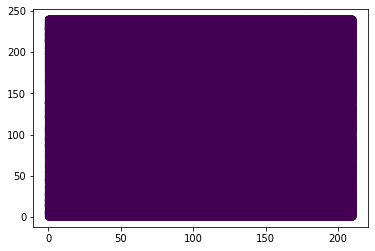

In [40]:
plt.scatter(x,z,c=weight_values)

No handles with labels found to put in legend.


Text(0, 0.5, 'int_point_z (cm)')

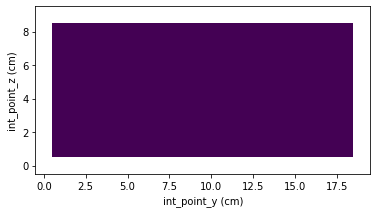

In [17]:
plt.imshow(grid_z0, origin='lower')

# plt.scatter(x,y,c=)

plt.legend(frameon=False)
plt.xlabel(f'{variable_1} (cm)')
plt.ylabel(f'{variable_2} (cm)')

## Event rate vs ee energy for different ctaus

In [105]:
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.pyplot import *
from matplotlib.patches import FancyArrowPatch


In [281]:
def plot_var_postsel_and_cut(myexp, variable, m4, mz, ctaus, \
                             selection_step='no_cuts', 
                             smooth_m4=0.005, 
                             smooth_mz=0.05, 
                             label_x='x',
                             bins=10,
                             xrange=(0,5),
                             colors=None,
                             left_cut=None,
                             right_cut=None,
                             normed=False):
    
    fsize=11
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
    params={'axes.labelsize':fsize,'xtick.labelsize':fsize,'ytick.labelsize':fsize,\
                'figure.figsize':(1.5*3,1.5*2.4)	}
    rc('font',**{'family':'serif', 'serif': ['computer modern roman']})
    plt.rcParams['hatch.linewidth'] = 0.3
    rcParams.update(params)
    axes_form  = [0.14,0.17,0.82,0.74]
    fig = plt.figure()
    ax = fig.add_axes(axes_form)
        
    m4_values = myexp.df_base['m4'].values
    mz_values = myexp.df_base['mzprime'].values
    
    df_values = np.stack([m4_values, mz_values], axis=-1)
    
    this_kde_weights = myexp.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

    myexp.decay_in_tpc(myexp.df_base, ctaus)
    
    for ctau in ctaus:
        weight_values = this_kde_weights *\
                        myexp.df_base['actual_weight'].values *\
                        myexp.df_base[selection_step].values *\
                        myexp.df_base[f'decay_in_tpc_{ctau}'].values

        if colors is not None:
            color=colors[ctaus.index(ctau)]
        else:
            color='black'
            
        out = plt.hist(myexp.df_base[variable], 
                       bins=bins, 
                       range=xrange,
                       weights=weight_values, 
                       label=f"ctau = {ctau} cm, nevt = {weight_values.sum():.0f} $\pm$ {np.sqrt((weight_values**2).sum()):.0f}", 
                       histtype='step',
                       lw=1.5,
                      density=normed,
                      color=color)

    y1, y2 = ax.get_ylim()
    x1, x2 = ax.get_xlim()

    if left_cut is not None:
        leftArrow = FancyArrowPatch(posA=(left_cut-(x2-x1)/15, (y2-y1)*0.8), posB=(left_cut, (y2-y1)*0.8), arrowstyle='<|-',
                          mutation_scale=20, shrinkA=0, shrinkB=0, color='black')
        ax.add_artist(leftArrow)
        ax.axvline(left_cut,c='black')

    if right_cut is not None:
        rightArrow = FancyArrowPatch(posA=(right_cut, (y2-y1)*0.8), posB=(right_cut+(x2-x1)/15, (y2-y1)*0.8), arrowstyle='-|>',
                              mutation_scale=20, shrinkA=0, shrinkB=0, color='black')
        ax.add_artist(rightArrow)
        ax.axvline(right_cut,c='black')

    plt.legend(frameon=False)
    ax.set_xlabel(label_x)
    return fig, ax


<ipython-input-281-b1060388782f>:15: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [


(<Figure size 324x259.2 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x13219d940>)

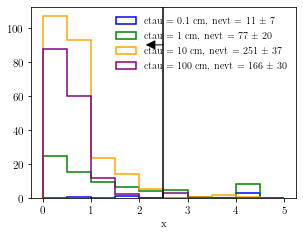

In [282]:
ctaus = [0.1, 1, 10, 100]
colors = ['blue', 'green', 'orange', 'purple', 'red']

m4 = 0.12
mz = 1.25

variable = ('ee_momentum')
selection_step = 'cut_based'
cut=0.150
plot_var_postsel_and_cut(my_exp_analysis, 'ee_energy', m4, mz, ctaus, 
                         selection_step, 
                         smooth_m4=0.05, 
                         smooth_mz=0.1, 
                         left_cut=2.5,
                        colors=colors)
#                         right_cut=0.8)

# Standard HNL comparison

In [283]:
from fourvec import *

In [333]:
df_std = pd.read_pickle(f'../standardHNL/data/MC_m4_0.15_mzprime_1.25.pckl')
# compute useful variables
for df in [df_std]:
    for comp in ['t','x','y','z']:
        df['pee', comp] = df['plm', comp] + df['plp', comp]
        df['pdark', comp] = df['plm', comp] + df['plp', comp] + df['pnu', comp]
    df['recoil_mass', ''] = inv_mass(df['pHad']).round(6)
    df['ee_mass', ''] = inv_mass(df['pee'])
    df['ee_costheta', ''] = costheta(df['plm'], df['plp'])
    df['ee_beam_costheta', ''] = df['pee', 'z']/np.sqrt(dot3_df(df['pee'], df['pee']))
    df['ee_momentum', ''] = np.sqrt(dot3_df(df['pee'], df['pee']))
    df['experimental_t', ''] = (df['plm','t'] - df['plm','z'] + df['plp','t'] - df['plp','z'])**2 +\
                                   df['plm','x']**2 + df['plm','y']**2 + df['plp','x']**2 + df['plp','y']**2
    
# weights
wstd=df_std['weight', '']/np.sum(df_std['weight', ''])


In [334]:
save_dir='../plots/stdHNL/'

In [375]:
case = 'heavy'
D_or_M = 'majorana'
m4mz=(0.15, 1.25)

my_exp_analysis = exp_analysis(case, D_or_M)
my_exp_analysis.load_df(0.15, 1.25)
no_scan = my_exp_analysis.dfs[m4mz]
selected_df = no_scan.query('cut_based')

loading df 0.15, 1.25
initialising df 0.15, 1.25


In [386]:
ctau=0.1
my_exp_analysis.decay_in_tpc(no_scan, ctau)
weights_geometric = no_scan[f'decay_in_tpc_{ctau}']

In [389]:
actual_weights = selected_df['actual_weight']
actual_weights *= weights_geometric

var='ee_momentum'

no_scan_pred, bin_edges = np.histogram(selected_df[var],
                            range=[0,5],
                            bins=10,
                            weights=actual_weights,
                            )
no_scan_pred_err = np.histogram(selected_df[var],
                            range=[0,5],
                            bins=10,
                            weights=actual_weights**2,
                            )[0] 


In [11]:
EMAX=8.0
bins=8

ctaus = [2, 10]
m4 = 0.15
mz = 1.25
variable = ('ee_momentum')
selection_step = 'cut_based'
cut=0.150
fig, ax = plot_var_postsel_and_cut(my_exp_analysis, 'ee_energy', m4, mz, ctaus, 
                                    selection_step, 
                                    smooth_m4=0.03, 
                                    smooth_mz=0.1, 
                                    right_cut=0.140,
                                    normed=True,
                                    bins=bins,
                                   colors=['red','forestgreen'],
                                    xrange=(0,EMAX))

# now generated prediction
ax.errorbar((bin_edges[1:]+bin_edges[:-1])/2, no_scan_pred, 
            yerr=np.sqrt(no_scan_pred_err),
            fmt='k.',
            label=f'no scanning: {no_scan_pred.sum():.2g} '\
            f'$\pm$ {100*np.sqrt(no_scan_pred_err.sum())/no_scan_pred.sum():.2g}%')

out = ax.hist(df_std['ee_momentum', ''], 
               bins=bins, 
               range=(0, EMAX),
               weights=wstd, 
               label='standard decay-in-flight HNL',
                facecolor='None',
              edgecolor='royalblue',
              lw=0.5,
               histtype='bar',
            hatch='////',
             density=True)


out = ax.hist(df_std['ee_momentum', ''], 
               bins=bins, 
               range=(0, EMAX),
               weights=wstd, 
                facecolor='None',
              edgecolor='royalblue',
              lw=1.0,
               histtype='bar',
             density=True)

ax.legend(loc='upper right',frameon=False)
ax.set_xlabel(r"$|\vec{p}_{e^+e^-}|$ (GeV)")
ax.set_ylabel(r"a.u.")
ax.set_xlim(0.,EMAX)
ax.set_title(r"$m_4 = 150$ MeV -- all inclusive",fontsize=fsize)
plt.savefig(f"{save_dir}/ee_momentum.png", dpi=400)

NameError: name 'plot_var_postsel_and_cut' is not defined